We will build 

* (A) Convert words to embedding (Use a pretrained word2vec from Google News)
* (B) Compute t-SNE of the embedding
* (C) Compute a CNN to map embedding to t-SNE dimensional reduction
* (D) Compute embeddings of sequences
* (E) Use seq2seq between word (embedded) sequences and word (embedded) sequences

The production system will be something like A/D -> E -> C



In [1]:
import numpy as np
import pandas as pd

# We will use pretrained word2vec weights

In [2]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

In [3]:
# Using a slimmed down version of Google News Word2Vec
# URL: https://github.com/eyaler/word2vec-slim
word_vectors = KeyedVectors.load_word2vec_format('/Users/fcucchietti/tmp/GoogleNews-vectors-negative300-SLIM.bin', binary=True)
EMBEDDING_DIM=300
print ("There are "+str(len((word_vectors.vocab)))+" words in this embedding")

There are 299567 words in this embedding


Let's clean duplicates with varying capitalizations (why did they leave them???)

In [4]:
def tokenize(orig_word):
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\''
    word = orig_word.lower()
    for f in filters:
        word=word.replace(f,"")
    return word

In [5]:
tokenizedVocab=set([])
w2v={}
for orig_word in word_vectors.vocab:
    word = tokenize(orig_word)
    if word not in tokenizedVocab:
        tokenizedVocab.add(word)
        w2v[word]=word_vectors[orig_word]
tokenizedVocab=list(tokenizedVocab)

In [6]:
li=np.zeros((len(tokenizedVocab)+1, EMBEDDING_DIM))
i2w={}
w2i={}
for idx,word in enumerate(tokenizedVocab):
    w2i[word]=idx
    i2w[idx]=word
    li[idx] = w2v[word]
df = pd.DataFrame(li)
del word_vectors

In [8]:
print ("Kept only "+str(len(df))+" unique words (uncased)")

Kept only 178602 unique words (uncased)


## Make a t-SNE representation

In [ ]:
# Option 1, save it to file and do it on the CLI
df.to_csv("word2vecEmbeddings.tsv",sep="\t",index=False,header=False)

In [ ]:
# Option 2, do it here (doesn't work in my Mac??)
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_jobs=4,perplexity=40,n_iter=20000,verbose=1)
tsne_representation = tsne.fit_transform(li)

### Once tsne is finished, we read it back in and add the index number and the word associated to each position

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
tsne = pd.read_csv("tsne_180Kw2v.tsv",header=None,sep="\t",names=["x","y"])

In [39]:
tsne["word"]=tokenizedVocab+["not_in_dic"]

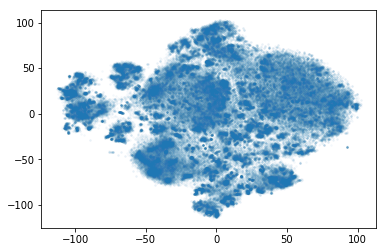

In [41]:
plt.scatter(tsne.x, tsne.y,alpha=0.05, s=5, linewidths=0)

### Clustering is hard so maybe categorize the text in part of speech categories

In [ ]:
from nltk.corpus import wordnet as wn

In [67]:
poses=[]
for w in tokenizedVocab:
    syns = wn.synsets(w)
    if len(syns)==0:
        syns = wn.synsets(wn.morphy('w'))
    pos = list(set([ x.pos() for x in syns ]))
    pos.sort()
    if len(pos)==0:
        pos=["0"]
    poses.append("".join(pos))

In [68]:
tsne["pos"]=poses+["0"]

In [71]:
tsne.pos.unique()

array([u'n', u'nv', u'sv', u'as', u'v', u'r', u'a', u's', u'nsv', u'an',
       u'anrsv', u'ansv', u'ans', u'ns', u'asv', u'av', u'anrs', u'nr',
       u'anr', u'nrs', u'rs', u'anv', u'ars', u'arsv', u'ar', u'nrsv',
       u'rv', u'rsv', u'nrv', '0'], dtype=object)

In [72]:
tsne["posInt"]=tsne.pos.astype("category").cat.codes

In [74]:
tsne.head()

,x,y,word,pos,posInt
0,56.242528,-30.031134,biennials,n,15
1,17.223312,29.899821,tripolitan,n,15
2,8.999858,-74.114660,chameleone,n,15
3,39.084687,-34.914781,nunnery,n,15
4,-34.378158,44.550147,prologistix,n,15


In [75]:
# Save to disk to visualize someplace else
tsne.to_csv("180word2vec_tSNE.csv",encoding="utf8")

# Read movie conversations

In [10]:
convoIds = []
with  open("cornell_movie_dialogs/movie_conversations.txt") as fi:
    contents = fi.read().decode("UTF-8").split("\n")
    for line in contents:
        sline=line.split("+++$+++")
        if (len(sline)==4): 
            convos = sline[3].strip()
            convos = convos.replace("'","").replace("[","").replace("]","").replace(",","").split(" ")
            for n in range(len(convos)-1):
                convoIds.append((convos[n],convos[n+1]))
print ("Found "+str(len(convoIds))+" pairs of conversations")

Found 221616 pairs of conversations


In [11]:
with  open("cornell_movie_dialogs/movie_lines.txt") as fi:
    contents = fi.read().decode("latin-1").split("\n")
    movie_lines = []
    for line in contents:
        sline=line.split("+++$+++")
        if (len(sline)>=5):        
            ID = sline[0].strip()
            convo = sline[4].strip()+"\n"
            movie_lines.append([ID,convo])
    movie_lines_df=pd.DataFrame(movie_lines,columns=["Id","line"]).set_index('Id')
print ("Found "+str(len(movie_lines))+" lines total")

Found 304713 lines total


In [12]:
convoSequences = []
for id1,id2 in convoIds:
    convoSequences.append((movie_lines_df.loc[id1].line,movie_lines_df.loc[id2].line)) 

In [13]:
convoSequences_df=pd.DataFrame(convoSequences,columns=["line1","line2"])

## Tokenize the texts

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence

/Users/fcucchietti/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
all_texts = movie_lines_df.line.values

In [16]:
tokenized_texts = [text_to_word_sequence(sentence,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'') for sentence in all_texts]
tokenized_questions = [text_to_word_sequence(sentence,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'') for sentence in convoSequences_df.line1.values]
tokenized_answers = [text_to_word_sequence(sentence,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'') for sentence in convoSequences_df.line2.values]

## Finally convert sequences of tokenized words into sequences of embedding coordinates

In [19]:
# missing words will get assigned ... a random embedding
def ran_word():
    return np.random.random(EMBEDDING_DIM)

In [24]:
NOTINDIC = len(tokenizedVocab)

In [21]:
# finish tokenization of sequences
#all_sequences = [ [word_vectors[w2v[word]] if word in tokenizedVocab else ran_word() for word in seq] for seq in tokenized_texts ]
sequences_questions = [ [ w2i[(word)] if word in w2i else ran_word() for word in seq] 
                       for seq in tokenized_questions ]

In [22]:
sequences_answers = [ [w2i[(word)] if word in w2i  else ran_word() for word in seq] for seq in tokenized_answers ]

### Some examples of sentences for plotting

In [25]:
# I need the indices of words in sentences to plot them in tSNE
some_sentences = [ [ w2i[(word)] if word in w2i else NOTINDIC for word in seq] 
                  for seq in tokenized_answers[:100] ]#np.random.choice(tokenized_answers,100)]
#with open("some_sentences.csv",'w') as fo:
#    for seq in some_sentences:
#        fo.write(",".join([str(x) for x in seq])+"\n")

In [27]:
import json
with open("some_sentences_3.csv",'w') as fo:
    fo.write(json.dumps([[str(x) for x in sen] for sen in some_sentences]))

In [78]:
[i2w[w] if w<NOTINDIC else "NID" for w in some_sentences[40]]

[u'okay',
 u'you',
 u're',
 u'gonna',
 u'need',
 u'to',
 u'learn',
 u'how',
 u'to',
 u'lie']

# Clusterization (not working)

In [ ]:
import hdbscan

In [ ]:
df.head()

In [ ]:
clusterer = hdbscan.HDBSCAN(algorithm='boruvka_kdtree')
clusterer.fit(df.values)
labels = clusterer.labels_

In [ ]:
labels[:5]

In [ ]:
tsne["cluster"]=labels

In [ ]:
tsne.to_csv("word2vec_tSNE_HDBSCAN.csv",encoding="utf8")

In [ ]:
plt.scatter(tsne.x, tsne.y,alpha=0.05, s=5, linewidths=0)

# seq2seq chatbot (WIP)

In [ ]:
# CAREFUL WITH THESE LINES THEY CAN CRASH PYTHON
all_inputs = pad_sequences(all_sequences)
X_input = pad_sequences(sequences_question,maxlen=all_inputs.shape[1])
y_output = pad_sequences(sequences_answer,maxlen=all_inputs.shape[1])
print('Shape of input and output tensors:', X_input.shape,y_output.shape)